# Summary

Dans ce notebook, nous allons mettre en pratique les algorithmes de regression sur un jeu de données relatif aux prix de biens immobilliers à Ames, Iowa.

Pour rappel, voici **quelques étapes de travail** d'un **Data Scientist** sont les suivantes:

<img src=attachment:f51f71af-8592-414e-a490-2c6d3bbcfe46.png width=700>


**Outils:**
- **Collecte et exploration des données**: pandas, polar, missingno, ydata-profiling, seaborn, plotly, ...
- **Modélisaion**: lazypredict sklearn, xgboost, lightgbm, catboost, yellowbricks, ...
- **Optimisation des hyperparamètres**: gridsearch (sklearn), optuna, hyperopt, ...
- **Déploiement**: mlflow, fastapi, evidently, heroku, pythonanywhere, azure webapp, ...
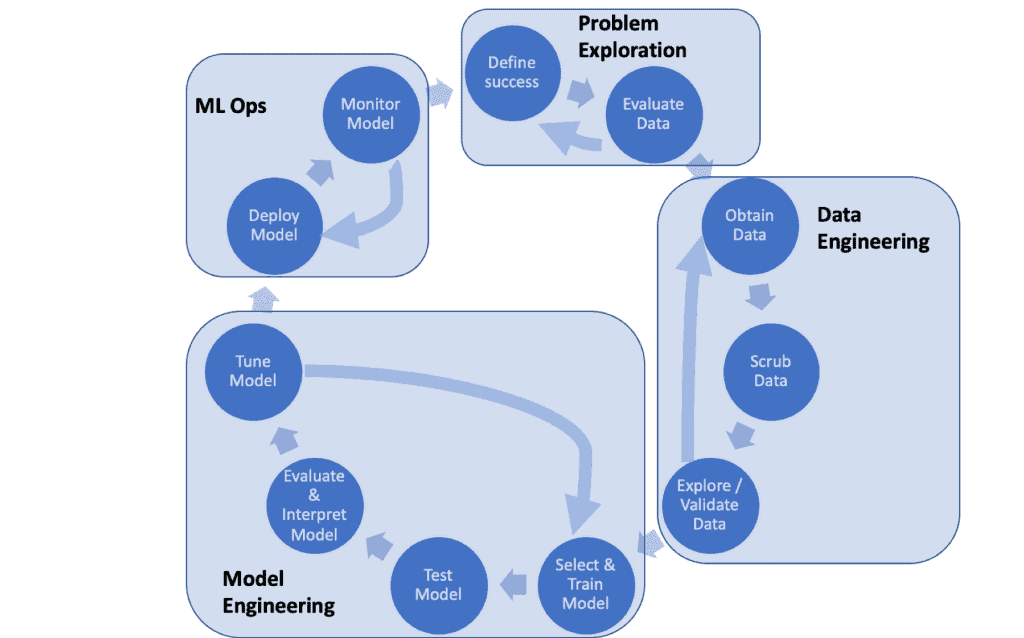

# Sources utiles

- [Introduction à MLOps](https://ashutoshtripathi.com/2021/08/18/mlops-a-complete-guide-to-machine-learning-operations-mlops-vs-devops/)

- [MLFLOW - Site de référence](https://mlflow.org/docs/latest/index.html)
- [MLFLOW - Tutorial](https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html)
- [MLFLOW - Tracking](https://mlflow.org/docs/latest/tracking.html)
- [MLFLOW - Model Registry](https://mlflow.org/docs/latest/model-registry.html#)
- [MLFLOW - Serve a model](https://mlflow.org/docs/latest/model-registry.html#serving-an-mlflow-model-from-model-registry)

- [Evidently - tutorial d'analyse de Data drift](https://github.com/evidentlyai/evidently/tree/main/examples/sample_notebooks)
- [API Flask - Démarche de mise en oeuvre](http://web.univ-ubs.fr/lmba/lardjane/python/c4.pdf)
- [FastAPI - Démarche de mise en oeuvre](https://towardsdatascience.com/how-to-build-and-deploy-a-machine-learning-model-with-fastapi-64c505213857)
- [Azure - Tuto déploiement application web ](https://learn.microsoft.com/fr-fr/azure/app-service/quickstart-python?tabs=flask%2Cwindows%2Cazure-portal%2Cvscode-deploy%2Cdeploy-instructions-azportal%2Cterminal-bash%2Cdeploy-instructions-zip-azcli)
- [Tests unitaires - Unittest ou Pytest](https://www.sitepoint.com/python-unit-testing-unittest-pytest/)

- [Pythonanywhere](https://www.pythonanywhere.com/)
- [Heroku](https://www.heroku.com/)
-[Azure webapp - Déploiement automatisé via Github](https://learn.microsoft.com/fr-fr/azure/app-service/deploy-continuous-deployment?tabs=github)
- Streamlit ou gradio pour la mise en place d'un dashbord


# Librairies

In [24]:
str(Path.cwd().parent)

'/Users/mouslydiaw/Downloads/sen-ia/house_price'

In [30]:
# reload modules before executing user code.
%reload_ext autoreload
%autoreload 2

import sys
from pathlib import Path

import dill
import matplotlib.pyplot as plt
import missingno as msno
import mlflow
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import pendulum
import seaborn as sns
from loguru import logger
# from pycaret.regression import *
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             max_error,
                            )
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot


sys.path.append(str(Path.cwd().parent))
from settings.params import (DATA_DIR_INPUT,
                             DATA_DIR_OUTPUT,
                             MODEL_PARAMS,
                             REPORT_DIR,
                             TIMEZONE,
                            )
from src.make_dataset import load_data
from src.trainer import Trainer


set_config(display="diagram", print_changed_only=False)
pd.set_option("display.max_columns", None)

# Settings

In [2]:
# time in UTC
log_fmt = ("<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | "
           "<cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
          )
log_config = {
    "handlers": [
        {"sink": sys.stderr, "format": log_fmt},
    ],
}
logger.configure(**log_config)


[1]

In [3]:
EXECUTION_DATE = pendulum.now(tz=TIMEZONE)

logger.info(f"Execution date: {EXECUTION_DATE}")

logger.info(f"\nData input directory : {DATA_DIR_INPUT}\nData output directory: {DATA_DIR_OUTPUT}")


# model parameters
FEATURES = MODEL_PARAMS.get("FEATURES")
TARGET_NAME = MODEL_PARAMS["TARGET"]

2023-07-19 22:42:07.279 | INFO     | __main__:<cell line: 3>:3 - Execution date: 2023-07-19T22:42:07.279175+00:00
2023-07-19 22:42:07.280 | INFO     | __main__:<cell line: 5>:5 - 
Data input directory : /Users/mouslydiaw/Downloads/sen-ia/house_price/data/input
Data output directory: /Users/mouslydiaw/Downloads/sen-ia/house_price/data/output


# Data Collection

In [4]:
data = load_data(dataset_name="house_prices", column_to_lower=True)

2023-07-19 22:42:07.521 | INFO     | src.make_dataset:load_data:24 - 
Args: dataset name: house_prices 
column to lower: True
2023-07-19 22:42:07.882 | INFO     | src.make_dataset:load_data:30 - Shape of raw input features: (1460, 81)
2023-07-19 22:42:07.883 | INFO     | src.make_dataset:load_data:31 - Full description of the dataset
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL

In [5]:
data.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal,208500.0
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal,181500.0
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal,223500.0
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal,250000.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   float64
 1   mssubclass     1460 non-null   float64
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   float64
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   float64
 18  overallc

In [7]:
data.describe(include="all")

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN

# EDA: Exploratory Data Analysis

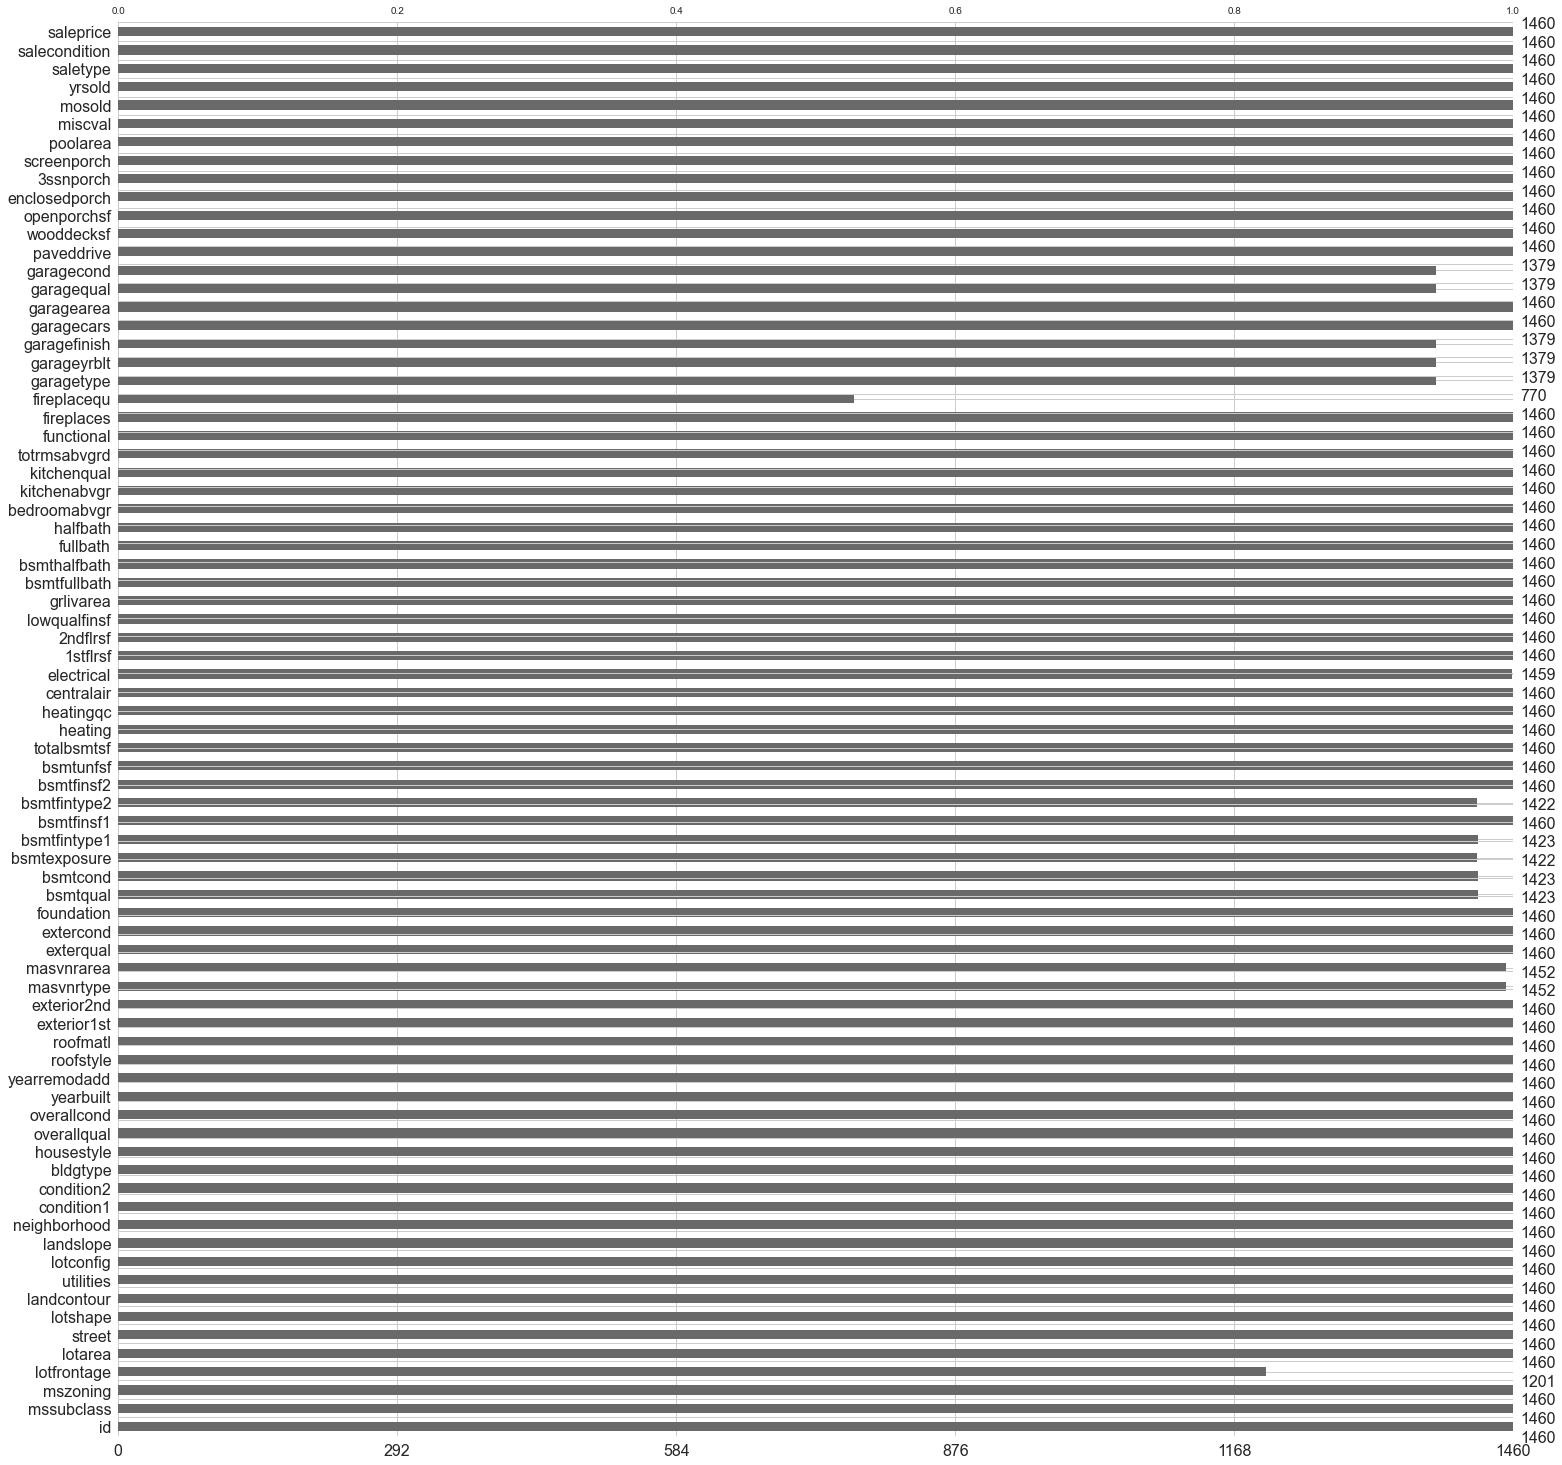

In [8]:
msno.bar(data,
         filter="top",  # select only features that have a completion rate >= p
         p=MODEL_PARAMS["MIN_COMPLETION_RATE"] # filter columns with % of missing values > 50%
        );

In [9]:
# Target: stat description
data[TARGET_NAME].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

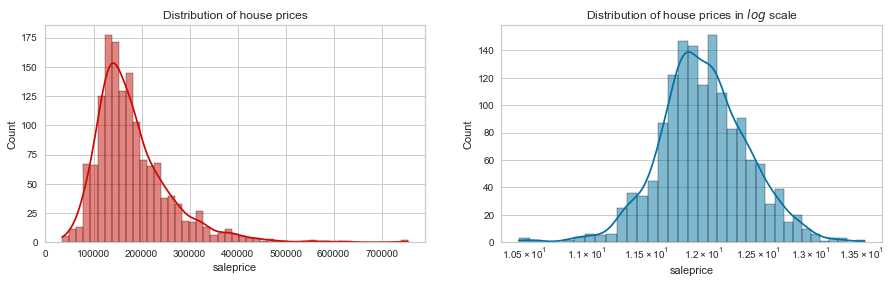

In [10]:
# Target distribution: raw vs log (box-cox transformation)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.histplot(data[TARGET_NAME], color='r', kde=True, ax=axes[0])
axes[0].set_title('Distribution of house prices')

sns.histplot(np.log(data[TARGET_NAME]), color='b', kde=True, ax=axes[1])
axes[1].set_title('Distribution of house prices in $log$ scale')
axes[1].set_xscale('log');

**Features**:
- 'bsmtfinsf1': 
- 'bsmtunfsf': 
- 'condition2': 
- 'exterqual': 
- 'foundation': 
- 'garagecars': 
- 'garagetype': 
- 'heating': 
- 'heatingqc': 
- 'housestyle': 
- 'lotarea': 
- 'masvnrarea': 
- 'masvnrtype': 
- 'miscfeature': 
- 'mosold': 
- 'mssubclass':
- 'mszoning'
- 'overallqual': 
- 'street': 
- 'totalbsmtsf'
- 'yearremodadd'
- 'yrsold'
- 'mosold',  # Month Sold (MM)
- "yearbuilt",  # Original construction date
- "yearremodadd",  # Remodel date (same as construction date if no remodeling or additions)|
- 'yrsold',  # Year Sold (YYYY)

**Target**: "saleprice"

In [11]:
msno.matrix(data.loc[:, FEATURES + [TARGET_NAME]], figsize=(12, 5));

KeyError: "['building_age', 'remodel_age'] not in index"

In [ ]:
categorical_features = data.select_dtypes(include=["object", "bool"]).columns
logger.info(f"Categorical features:\n {categorical_features}\n")

numerical_features = data.select_dtypes(include="number").columns
logger.info(f"Numerical features:\n {numerical_features}")

ncols = 2  # number of columns in subplot
nrows = sum(divmod(len(categorical_features), ncols))  # number of rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 30))
axes = axes.ravel()

for i, col_name in enumerate(categorical_features):
    ax = axes[i]
    sns.violinplot(x=col_name, y=TARGET_NAME, data=data, palette='husl', ax=ax)

In [ ]:
sns.heatmap(pd.crosstab(index=data.housestyle, columns=data.heating,
                        margins=False,
                        margins_name="Total", dropna=False),
            cmap="Greens", 
            annot=True,
            fmt='.2g',
           );  # px pour un graph interactif

In [ ]:
px.box(data_frame=data, x="heating", y=TARGET_NAME)

In [ ]:
px.box(data_frame=data, y=TARGET_NAME,
       x="housestyle", color="heating",
       title="Box plot",
       #hover_data=[Heating"],
       boxmode="group",
       #notched=True, # used notched shape
       points=None,
       width=900,
       height=500,
      )

In [ ]:
sns.scatterplot(x='totalbsmtsf', y=TARGET_NAME, data=data, palette='magma', hue='housestyle',);

# Feature engineering / selections

In [66]:
data.loc[:, ["yrsold", "mosold", "yearbuilt", "yearremodadd"]]

,yrsold,mosold,yearbuilt,yearremodadd
0,2008.0,2.0,2003.0,2003.0
1,2007.0,5.0,1976.0,1976.0
2,2008.0,9.0,2001.0,2002.0
3,2006.0,2.0,1915.0,1970.0
4,2008.0,12.0,2000.0,2000.0
...,...,...,...,...
1455,2007.0,8.0,1999.0,2000.0
1456,2010.0,2.0,1978.0,1988.0
1457,2010.0,5.0,1941.0,2006.0
1458,2010.0,4.0,1950.0,1996.0


In [ ]:
data.yearbuilt.value_counts().head(10)#plot(kind="bar", figsize=(15, 7));

2006.0    67
2005.0    64
2004.0    54
2007.0    49
2003.0    45
1976.0    33
1977.0    32
1920.0    30
1959.0    26
1998.0    25
Name: yearbuilt, dtype: int64

In [12]:
data = data.assign(building_age=lambda dfr: dfr.yrsold - dfr.yearbuilt,
                   remodel_age=lambda dfr: dfr.yrsold - dfr.yearremodadd
                  )
data.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,building_age,remodel_age
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal,208500.0,5.0,5.0
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal,181500.0,31.0,31.0
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal,223500.0,7.0,6.0
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml,140000.0,91.0,36.0
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal,250000.0,8.0,8.0


# Modeling

## Pipeline

![mlflow-tracking](https://mlflow.org/docs/latest/_images/quickstart_tracking_overview.png)

In [26]:
data.assign(col_bool=lambda dfr: 10).select_dtypes(include=["float", "int"])

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,building_age,remodel_age,col_bool
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0,5.0,5.0,10
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0,31.0,31.0,10
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0,7.0,6.0,10
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0,91.0,36.0,10
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0,8.0,8.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456.0,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,0.0,953.0,953.0,953.0,694.0,0.0,1647.0,0.0,0.0,2.0,1.0,3.0,1.0,7.0,1.0,1999.0,2.0,460.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0,175000.0,8.0,7.0,10
1456,1457.0,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,163.0,589.0,1542.0,2073.0,0.0,0.0,2073.0,1.0,0.0,2.0,0.0,3.0,1.0,7.0,2.0,1978.0,2.0,500.0,349.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2010.0,210000.0,32.0,22.0,10
1457,1458.0,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,0.0,877.0,1152.0,1188.0,1152.0,0.0,2340.0,0.0,0.0,2.0,0.0,4.0,1.0,9.0,2.0,1941.0,1.0,252.0,0.0,60.0,0.0,0.0,0.0,0.0,2500.0,5.0,2010.0,266500.0,69.0,4.0,10
1458,1459.0,20.0,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,1029.0,0.0,1078.0,1078.0,0.0,0.0,1078.0,1.0,0.0,1.0,0.0,2.0,1.0,5.0,0.0,1950.0,1.0,240.0,366.0,0.0,112.0,0.0,0.0,0.0,0.0,4.0,2010.0,142125.0,60.0,14.0,10


In [29]:
# Create model
reg = define_pipeline(numerical_transformer=numeric_transformer,
                      categorical_transformer=categorical_transformer,
                      estimator=LinearRegression()
                     )
reg

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose='deprecated')),
                                                                  ('standardscaler',
                                                                   StandardS...
                                                                                 handle_unknown='ignore',
                                                                                 max_categories=None,
                                                                                 min_frequency=None,
                                                                                 sparse=True))],
                                                           verbose=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ffb82223fd0>)],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('estimator',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize='deprecated', positive=False))],
         verbose=False)

## Train / test split

In [ ]:
data.loc[:, FEATURES]

KeyError: "['building_age', 'remodel_age'] not in index"

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data.loc[:, FEATURES],
                                                    data[TARGET_NAME],
                                                    test_size=MODEL_PARAMS["TEST_SIZE"],
                                                    random_state=23)
logger.info(f"\nX train: {x_train.shape}\nY train: {y_train.shape}\n"
            f"X test: {x_test.shape}\nY test: {y_test.shape}")

In [34]:
mlflow.set_tracking_uri("http://192.168.0.1:5000")
mlflow.autolog()  # Or other tracking functions

2023/07/19 23:30:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/07/19 23:30:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


## Baseline

### Training

In [ ]:
interpret_model()

In [33]:
exp = setup(data,
        
            target=TARGET_NAME,
            keep_features=FEATURES,
            session_id=1,
            log_experiment=False,
            use_gpu=False,
           )

AttributeError: module 'pycaret' has no attribute 'containers'

In [ ]:
# Compare Baseline
best = exp.compare_models(fold=3)

In [ ]:
# evaluate trained model
exp.evaluate_model(best)

In [43]:
trainer = Trainer(data=data,
                  target=TARGET_NAME,
                  features=None,
                  numerical_transformer=numeric_transformer,
                  categorical_transformer=categorical_transformer,
                  estimator=LinearRegression()
                 )
trainer.fit()

2023-07-19 22:15:29.714 | INFO     | src.trainer:__init__:27 - Test size: None | cross validation: None
2023-07-19 22:15:29.719 | INFO     | src.trainer:__init__:36 - Train size: 1095 | Test size: 365
2023-07-19 22:15:29.759 | INFO     | src.trainer:define_pipeline:73 - Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fi

{'rmse': 18660.998520990932, 'mae': 12545.080548238342, 'r2': 0.943895679708393, 'max_error': 131629.09327269194}
{'rmse': 33023.038926172725, 'mae': 18326.172500594712, 'r2': 0.8347344123411938, 'max_error': 404607.30112901796}


In [ ]:
# pycaret
# lazy_predict


# 5 modèles
# Expérimentation des modèles à stocker et suivre avec MLFlow

### Model évaluation

In [33]:
# Use the model to make predictions on the test dataset.
predictions = reg.predict(x_test)

In [ ]:
# Définir les métriques d'évaluation que vous souhaitez utiliser

## Tuning

In [ ]:
# optuna
# hyperopt
# GridSearch (sklearn)
# Pycaret*


In [ ]:
tuned_lightgbm = tune_model(lightgbm,
                            n_iter=30,
                            optimize = 'MAE',
                            tuner_verbose=True,
                            search_library="optuna",
                            search_algorithm="tpe",
                            custom_grid=None,
                            early_stopping=True,
                            early_stopping_max_iters=3,
                            
                           )


# Model analysis & validation

In [ ]:
plot_model(dt)

In [ ]:
plot_model(dt, plot = 'error')


## Features importances

In [ ]:
plot_model(dt, plot = 'feature')


In [ ]:
interpret_model(lightgbm)


In [ ]:
interpret_model(lightgbm, plot = 'correlation')


## AutoML

In [ ]:
best = automl(optimize = 'MAE')
best

## Data drift

In [ ]:
# evidently

# Déploiement

In [ ]:
###

In [ ]:
# sauvargade du modèle en local: dill, joblib (sklearn), pickle, pycaret

save_model(best, model_name='best-model')


In [ ]:
loaded_bestmodel = load_model('best-model')
print(loaded_bestmodel)

# MLFlow UI

In [ ]:
!mlflow ui

In [25]:
import session_info

In [31]:
session_info.show()

KeyError: 'lightgbm'

In [28]:
!pip unsinstall ligthgbm -y

ERROR: unknown command "unsinstall" - maybe you meant "uninstall"
